# Using transcoders to reverse-engineer GELU-1L SAE features

## Background

### SAEs and reverse-engineering

SAEs are a really cool interpretability tool that learn (in an unsupervised way) to decompose the internal activations of a model into a sparse linear combination of interpretable *feature vectors*. Examples of feature vectors found by SAEs on various models have included features that fire on base64 text, features that fire on certain ranges of years, features that fire in a theological/philosophical context, and many, many others. By looking at which SAE features are activated on a given input, we can better understand what the model is "thinking" as it processes that input.

But there's a catch: SAE features don't come with nametags. In other words, we don't know what a given SAE feature means *a priori*. In order to understand an SAE feature, people will look at which inputs cause the SAE feature to fire, and then try and find patterns in these inputs. But this relies on human pattern recognition, which can fail to capture the actual computation reflected by the SAE feature!

To address this, we'll try and reverse-engineer some SAE features. By understanding mechanistically what causes a given SAE feature to fire, we can interpret these features on their own terms, and gain a more robust understanding of what they mean.

### Transcoders

In our reverse-engineering process, we'll make use of a tool called "transcoders". Transcoders are like SAEs, but with a key difference. You see, SAEs take the model's hidden state at a given point as input, and reconstruct that hidden state as a sparse linear combination of features. In contrast, transcoders take as input the input to an MLP sublayer, and then reconstruct the *output of that MLP sublayer* as a sparse linear combination of features. In effect, transcoders aim to implement the same computation as a given MLP sublayer, but in a "sparsified" way that allows us to interpret this computation better. 

## About this notebook

### Model, SAE, transcoder

In this notebook, we'll be reverse-engineering SAE features for a one-layer language model called `GELU-1L`. Because this is a one-layer model, after the initial token embeddings, there is a single attention sublayer, followed by a single MLP sublayer, followed by the logit unembeddings. The SAE features that we'll be reverse-engineering will "live" in the output space of the MLP sublayer. We'll be making use of a transcoder that approximates the computation of the MLP sublayer, mapping from the input space of the MLP to the output space.

### Case studies

We'll provide a few examples of case studies for reverse-engineering SAE features in this notebook. Based on these examples, you'll be able to then run your own case studies and do your own reverse-engineering.

## Caveats and warnings

Note that this notebook is currently a reflection of in-progress work. As such, there are a few minor technical caveats to be aware of when using this notebook. The casual reader should feel free to skip these caveats, but the technically-inclined should note that I am aware of them, and that more recent unreleased notebooks that I've been working on address these caveats.

<details>
    <summary>Technical caveats</summary>
    
* Currently, this notebook only reverse-engineer the OV circuits of attention sublayers. There are ways to incorporate QK circuits into this sort of analysis, but they are not addressed in this notebook.
* Currently, this notebook ignores LayerNorm nonlinearities in its analysis. There are mathematically principled reasons why LayerNorm should not affect the relative importance of attributions in the same computational path (e.g. tokens in a de-embedding or attention heads in a DFA, but comparing attributions across different computational paths (e.g. the de-embedding in the direct path versus the de-embedding through an attention head) is currently ill-founded. There is a way to address this by taking into account LayerNorm scale factors, but this notebook does not do so.

</details>


# Setup and utility functions

This section performs setup (importing dependencies, loading our model, and loading a dataset) and defines a number of functions that will be used in the reverse-engineering process. Feel free to skip reading the code in this section, but you do need to run these cells before continuing onward.

## Dependencies

In [1]:
import transformer_lens
from transformer_lens import HookedTransformer, utils
import torch
import numpy as np
import pprint
import json
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from huggingface_hub import HfApi
from IPython.display import HTML
from functools import partial
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'stix'

/gpfs/gibbs/project/cohan/jhd43/conda_envs/nlp_env/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/gpfs/gibbs/project/cohan/jhd43/conda_envs/nlp_env/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## Load model

In [2]:
model = HookedTransformer.from_pretrained('gelu-1l')

Loaded pretrained model gelu-1l into HookedTransformer


## Loading data

In [59]:
# Thanks to Neel Nanda for this code
import einops
def tokenize_and_concatenate(
    dataset,
    tokenizer,
    streaming = False,
    max_length = 1024,
    column_name = "text",
    add_bos_token = True,
):
    """Helper function to tokenizer and concatenate a dataset of text. This converts the text to tokens, concatenates them (separated by EOS tokens) and then reshapes them into a 2D array of shape (____, sequence_length), dropping the last batch. Tokenizers are much faster if parallelised, so we chop the string into 20, feed it into the tokenizer, in parallel with padding, then remove padding at the end.

    This tokenization is useful for training language models, as it allows us to efficiently train on a large corpus of text of varying lengths (without, eg, a lot of truncation or padding). Further, for models with absolute positional encodings, this avoids privileging early tokens (eg, news articles often begin with CNN, and models may learn to use early positional encodings to predict these)

    Args:
        dataset (Dataset): The dataset to tokenize, assumed to be a HuggingFace text dataset.
        tokenizer (AutoTokenizer): The tokenizer. Assumed to have a bos_token_id and an eos_token_id.
        streaming (bool, optional): Whether the dataset is being streamed. If True, avoids using parallelism. Defaults to False.
        max_length (int, optional): The length of the context window of the sequence. Defaults to 1024.
        column_name (str, optional): The name of the text column in the dataset. Defaults to 'text'.
        add_bos_token (bool, optional): . Defaults to True.

    Returns:
        Dataset: Returns the tokenized dataset, as a dataset of tensors, with a single column called "tokens"

    Note: There is a bug when inputting very small datasets (eg, <1 batch per process) where it just outputs nothing. I'm not super sure why
    """
    for key in dataset.features:
        if key != column_name:
            dataset = dataset.remove_columns(key)

    if tokenizer.pad_token is None:
        # We add a padding token, purely to implement the tokenizer. This will be removed before inputting tokens to the model, so we do not need to increment d_vocab in the model.
        tokenizer.add_special_tokens({"pad_token": "<PAD>"})
    # Define the length to chop things up into - leaving space for a bos_token if required
    if add_bos_token:
        seq_len = max_length - 1
    else:
        seq_len = max_length

    def tokenize_function(examples):
        text = examples[column_name]
        # Concatenate it all into an enormous string, separated by eos_tokens
        full_text = tokenizer.eos_token.join(text)
        # Divide into 20 chunks of ~ equal length
        num_chunks = 20
        chunk_length = (len(full_text) - 1) // num_chunks + 1
        chunks = [
            full_text[i * chunk_length : (i + 1) * chunk_length]
            for i in range(num_chunks)
        ]
        # Tokenize the chunks in parallel. Uses NumPy because HuggingFace map doesn't want tensors returned
        tokens = tokenizer(chunks, return_tensors="np", padding=True)[
            "input_ids"
        ].flatten()
        # Drop padding tokens
        tokens = tokens[tokens != tokenizer.pad_token_id]
        num_tokens = len(tokens)
        num_batches = num_tokens // (seq_len)
        # Drop the final tokens if not enough to make a full sequence
        tokens = tokens[: seq_len * num_batches]
        tokens = einops.rearrange(
            tokens, "(batch seq) -> batch seq", batch=num_batches, seq=seq_len
        )
        if add_bos_token:
            prefix = np.full((num_batches, 1), tokenizer.bos_token_id)
            tokens = np.concatenate([prefix, tokens], axis=1)
        return {"tokens": tokens}

    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=[column_name],
    )
    #tokenized_dataset.set_format(type="torch", columns=["tokens"])
    return tokenized_dataset


In [4]:
dataset = load_dataset('Skylion007/openwebtext', split='train', streaming=True)
dataset = dataset.shuffle(seed=42, buffer_size=10_000)
tokenized_owt = tokenize_and_concatenate(dataset, model.tokenizer, max_length=128, streaming=True)
tokenized_owt = tokenized_owt.shuffle(42)
tokenized_owt = tokenized_owt.take(12800)
owt_tokens = np.stack([x['tokens'] for x in tokenized_owt])

In [5]:
owt_tokens_torch = torch.from_numpy(owt_tokens).cuda()

## Feature scores

In [85]:
def get_feature_scores(model, encoder, tokens_arr, feature_idx, batch_size=64, act_name='resid_pre', layer=0, use_raw_scores=False, use_decoder=False, feature_post=None, ignore_endoftext=False, use_tqdm=True):
  scores = []
  endoftext_token = model.to_single_token('<|EOS|>')
  tqdm_func = (lambda x: tqdm.tqdm(x)) if use_tqdm else (lambda x: x)
  for i in tqdm_func(range(0, tokens_arr.shape[0], batch_size)):
    #print(i, tokens_arr.shape[0], batch_size)
    with torch.no_grad():
      _, cache = model.run_with_cache(tokens_arr[i:i+batch_size], stop_at_layer=layer+1, names_filter=[
        utils.get_act_name(act_name, layer)
      ])
      mlp_acts = cache[utils.get_act_name(act_name, layer)]
      mlp_acts_flattened = mlp_acts.reshape(-1, encoder.W_enc.shape[0])
      if feature_post is None:
        feature_post = encoder.W_enc[:, feature_idx] if not use_decoder else encoder.W_dec[feature_idx]
      bias = -(encoder.b_dec @ feature_post) if use_decoder else encoder.b_enc[feature_idx] - (encoder.b_dec @ feature_post)
      if use_raw_scores:
        cur_scores = (mlp_acts_flattened @ feature_post) + bias
      else:
        _, hidden_acts, _, _, _, _ = encoder(mlp_acts_flattened)
        cur_scores = hidden_acts[:, feature_idx]
      if ignore_endoftext:
          cur_scores[tokens_arr[i:i+batch_size].reshape(-1) == endoftext_token] = -torch.inf
    scores.append(utils.to_numpy(cur_scores.reshape(-1, tokens_arr.shape[1])).astype(np.float16))
  return np.concatenate(scores)

In [7]:
def sample_percentiles(arr, num_samples):
    sample_idxs = []
    sample_vals = []
    
    num_samples = num_samples - 1
    p_step = 100./num_samples
    
    for p in np.arange(0,100,p_step):
        value_at_p = np.percentile(arr.reshape(-1), p, interpolation='nearest')
        p_idx = np.abs(arr-value_at_p).argmin()
        
        sample_vals.append(value_at_p)
        sample_idxs.append(np.unravel_index(p_idx, arr.shape))

    # get maximum
    value_at_p = np.max(arr)
    p_idx = np.abs(arr-value_at_p).argmin()

    sample_vals.append(value_at_p)
    sample_idxs.append(np.unravel_index(p_idx, arr.shape))
    
    return np.array(sample_vals), np.array(sample_idxs)

In [8]:
def sample_uniform(arr, num_samples, unique=True, use_tqdm=False, only_max_range=False):
    sample_idxs = []
    sample_vals = []

    max_val = np.max(arr)
    if not only_max_range:
        min_val = np.min(arr)
    else:
        min_val = -max_val

    num_samples = num_samples - 1
    p_step = 1./num_samples

    func = (lambda x: x) if not use_tqdm else (lambda x: tqdm.tqdm(x))
    
    for p in func(np.arange(0,1,p_step)):
        value_at_p = min_val + p * (max_val - min_val)
        p_idx = np.abs(arr-value_at_p).argmin()
        real_val = arr[np.unravel_index(p_idx, arr.shape)]
        sample_vals.append(real_val)
        sample_idxs.append(np.unravel_index(p_idx, arr.shape))

    # get maximum
    value_at_p = np.max(arr)
    p_idx = np.abs(arr-value_at_p).argmin()

    sample_vals.append(value_at_p)
    sample_idxs.append(np.unravel_index(p_idx, arr.shape))

    sample_vals = np.array(sample_vals)
    sample_idxs = np.array(sample_idxs)

    if unique:
        sample_vals, sample_pos = np.unique(sample_vals, return_index=True)
        sample_idxs = sample_idxs[sample_pos]
    
    return sample_vals, sample_idxs

## Feature dashboards

In [9]:
def get_percent_between_scores_vec(scores, num_bands, return_percentages=True):
    scores_max = scores.max()
    scores_min = scores.min()

    retlist = []
    denom = 1 if not return_percentages else np.prod(scores.shape)
    for band_idx in range(num_bands):
        low_score = scores_min + (scores_max-scores_min)*band_idx/num_bands
        high_score = scores_min + (scores_max-scores_min)*(band_idx+1)/num_bands
        #print(low_score, high_score)
        retlist.append(np.sum(np.logical_and(
            scores >= low_score, scores <= high_score
        ))/denom)
    return np.array(retlist)

In [145]:
import html

def batch_color_interpolate(scores, max_color, zero_color, scores_min=None, scores_max=None):
    max_color_vec = np.array([int(max_color[1:3], 16), int(max_color[3:5], 16), int(max_color[5:7], 16)])
    zero_color_vec = np.array([int(zero_color[1:3], 16), int(zero_color[3:5], 16), int(zero_color[5:7], 16)])
    
    if scores_min is None: scores_min = scores.min()
    if scores_max is None: scores_max = scores.max()
        
    if scores_max != scores_min: 
        scores_normalized = (scores - scores_min) / (scores_max - scores_min)    
        color_vecs = np.einsum('i, j -> ij', scores_normalized, max_color_vec) + np.einsum('i, j -> ij', 1-scores_normalized, zero_color_vec)
    else:
        color_vecs = np.tile(zero_color_vec, (len(scores),1))
        
    color_strs = [f"#{int(x[0]):02x}{int(x[1]):02x}{int(x[2]):02x}" for x in color_vecs]
    return color_strs

def make_sequence_html(token_strs, scores,
    scores_min=None,
    scores_max=None,
    max_color='#ff8c00',
    zero_color='#ffffff',
    return_head=False,
    cur_token_idx=None,
    window_size=None,
):
    #if scores_min is None: scores_min = scores.min()
    #if scores_max is None: scores_max = scores.max()
    #scores_normalized = (scores-scores_min)/(scores_max-scores_min)

    if window_size is not None:
        left_idx = np.max([0, cur_token_idx-window_size])
        right_idx = np.min([len(scores), cur_token_idx+window_size])
        scores = scores[left_idx:right_idx]
        #scores_normalized = scores_normalized[left_idx:right_idx]
        token_strs = token_strs[left_idx:right_idx]
        cur_token_idx = cur_token_idx - left_idx

    color_strs = batch_color_interpolate(scores, max_color, zero_color, scores_min=scores_min, scores_max=scores_max)

    #max_color_vec = np.array([int(max_color[1:3], 16), int(max_color[3:5], 16), int(max_color[5:7], 16)])
    #zero_color_vec = np.array([int(zero_color[1:3], 16), int(zero_color[3:5], 16), int(zero_color[5:7], 16)])

    #color_vecs = np.einsum('i, j -> ij', scores_normalized, max_color_vec) + np.einsum('i, j -> ij', 1-scores_normalized, zero_color_vec)
    #color_strs = [f"#{int(x[0]):02x}{int(x[1]):02x}{int(x[2]):02x}" for x in color_vecs]

    tokens_html = "".join([
        f"""<span class='token'
            style='background-color: {color_strs[i]}'
            onMouseOver='showTooltip(this)'
            onMouseOut='hideTooltip(this)'>{"<b>" if cur_token_idx is not None and i == cur_token_idx else ""}{html.escape(token_str)}{"</b>" if cur_token_idx is not None and i == cur_token_idx else ""}<span class='feature_val'> ({scores[i]:.2f})</span></span>"""
         for i, token_str in enumerate(token_strs)
    ])

    if return_head:
        head = """
<script>
    function showTooltip(element) {
        feature_val = element.querySelector('.feature_val')
        feature_val.style.display='inline'
    }

    function hideTooltip(element) {
        feature_val = element.querySelector('.feature_val')
        feature_val.style.display='none'
    }
</script>
<style>
    span.token {
        font-family: monospace;
        
        border-style: solid;
        border-width: 1px;
        border-color: #dddddd;
    }

    .feature_val {
        display: none;
        font-family: serif;
    }

    #tooltip {
        display: none;
    }
</style>
"""
        return head + tokens_html
    else:
        return tokens_html

def get_uniform_band_examples(scores, uniform_vals, uniform_idxs, num_bands, band_size, return_percentages=False):
    retlist = []
    
    total_num_exs = num_bands*band_size
    scores_min = scores.min() 
    scores_max = scores.max()
    bandwidth = (scores_max-scores_min)/total_num_exs
    denom = 1 if not return_percentages else np.prod(scores.shape)

    for band in range(0, total_num_exs+band_size, band_size):
        #print(band)
        low_score = scores_min + band*bandwidth
        high_score = scores_min + (band+band_size)*bandwidth
        num_examples_in_band = np.sum(np.logical_and(
            scores >= low_score, scores <= high_score
        ))/denom
        retlist.append((low_score, high_score, num_examples_in_band, uniform_idxs[np.logical_and(uniform_vals>=low_score, uniform_vals<=high_score)]))
    return retlist

def display_activating_examples_dash(all_tokens, scores,
     num_examples=50,
     num_bands=5,
     bandwidth=10,
     return_percentages=True,
     window_size=5
    ):

    display(HTML(f"<h3 style='font-family: serif'>Sparsity: {100*np.sum(scores > 0)/np.prod(scores.shape):.4f}%</h3>"))
    uniform_vals, uniform_idxs = sample_uniform(scores, num_examples, unique=True)
    unif_bands = get_uniform_band_examples(scores, uniform_vals, uniform_idxs, num_bands, bandwidth, return_percentages=return_percentages)
    for band in reversed(unif_bands):
        cur_html_list = [f"<details><summary><h3 style='display: inline; font-family: serif'>Between {band[0]:.2f} and {band[1]:.2f}: {100*band[2]:.4f}%</h3></summary>"]
        #display(HTML(f"<h3 style='font-family: serif'>Between {band[0]:.2f} and {band[1]:.2f}: {100*band[2]:.4f}%</h3>"))
        for example_idx, token_idx in band[3]:
            cur_html_list.append(
                make_sequence_html(
                    model.to_str_tokens(all_tokens[example_idx]), scores[example_idx],
                    scores_min=scores.min(), scores_max=scores.max(), return_head=True, cur_token_idx=token_idx, window_size=window_size
                ) + f"<span> Example {example_idx}, token {token_idx}</span>" + "<br/>"
            )
        cur_html_list.append("</details>")
        display(HTML("".join(cur_html_list)))

def get_logits_for_feature(model, sae, feature_idx, k=7):
    feature = sae.W_dec[feature_idx]

    with torch.no_grad():
        most_pos = torch.topk(feature @ model.W_U, k=k)
        most_neg = torch.topk(-feature @ model.W_U, k=k)
    
    top_vals = utils.to_numpy(most_pos.values)
    top_idxs = utils.to_numpy(most_pos.indices)
    top_tokens = model.to_str_tokens(top_idxs)
    
    bot_vals = utils.to_numpy(-most_neg.values)
    bot_idxs = utils.to_numpy(most_neg.indices)
    bot_tokens = model.to_str_tokens(bot_idxs)

    return zip(top_vals, top_tokens, bot_vals, bot_tokens)

def display_logits_for_feature(model, sae, feature_idx, k=7):
    logits = list(get_logits_for_feature(model, sae, feature_idx, k=k))

    table_html = """
<style>
    span.token {
        font-family: monospace;
        
        border-style: solid;
        border-width: 1px;
        border-color: #dddddd;
    }
</style>
<table>
    <thead>
        <tr>
            <th colspan=2 style='text-align:center'>Bottom logits</th>
            <th colspan=2 style='text-align:center'>Top logits</th>
        </tr>
    </thead>
    <tbody>
"""

    top_scores = np.array([x[0] for x in logits])
    bot_scores = np.array([x[2] for x in logits])
    scores_max = np.max(top_scores)
    scores_min = np.min(bot_scores)
    
    top_color_strs = batch_color_interpolate(top_scores, '#7f7fff', '#ffffff', scores_min=scores_min, scores_max=scores_max)
    bot_color_strs = batch_color_interpolate(-bot_scores, '#ff7f7f', '#ffffff', scores_min=scores_min, scores_max=scores_max)

    for i, (top_val, top_token, bot_val, bot_token) in enumerate(logits):
        row_html =\
f"""<tr>
    <td style='text-align:left'><span class='token' style='background-color: {bot_color_strs[i]}'>{html.escape(bot_token).replace(' ', '&nbsp;')}</span></td>
    <td style='text-align:right'>{bot_val:.3f}</td>
    <td style='text-align:left'><span class='token' style='background-color: {top_color_strs[i]}'>{html.escape(top_token).replace(' ', '&nbsp;')}</span></td>
    <td style='text-align:right'>+{top_val:.3f}</td>
</tr>"""
        table_html = table_html + row_html
    table_html = table_html + "</tbody></table>"
    display(HTML(table_html))

    all_logits = utils.to_numpy(sae.W_dec[feature_idx] @ model.W_U)

    fig, ax = plt.subplots()
    ax.hist(all_logits[all_logits < 0], color='#ff7f7f')
    ax.hist(all_logits[all_logits > 0], color='#7f7fff')
    fig.set_size_inches(5,2)
    plt.show()
    

In [11]:
def plot_pulledback_feature(model, sae, transcoder, feature_idx, size=None, do_plot=True,
                            input_layer=None, input_tokens=None, input_example=None, input_token_idx=None):
    if size is None: size=(5,3)
    with torch.no_grad():
        pulledback_feature = transcoder.W_dec @ sae.W_enc[:, feature_idx]

        if input_layer is not None:
            if type(input_example) is int and input_tokens is not None:
                prompt = input_tokens[input_example]
            elif type(input_example) is str:
                prompt = input_example
            # TODO: add list support
            _, cache = model.run_with_cache(prompt, stop_at_layer=input_layer+1,
                names_filter=utils.get_act_name(f'normalized{input_layer}ln2', input_layer)
            )
            feature_activs = transcoder(cache[utils.get_act_name(f'normalized{input_layer}ln2', input_layer)])[1][0,input_token_idx]
            pulledback_feature = pulledback_feature * feature_activs
            
    pulledback_feature = utils.to_numpy(pulledback_feature)

    if do_plot:
        score_max = np.max(np.abs([pulledback_feature.max(), pulledback_feature.min()]))
        score_min = -np.min(np.abs([pulledback_feature.max(), pulledback_feature.min()]))
        colors = batch_color_interpolate(pulledback_feature, '#7f7fff', '#ff7f7f')#, scores_min=score_min, scores_max=score_max)
        
        
        fig, ax = plt.subplots()
        ax.plot(pulledback_feature, alpha=0.5)
        ax.scatter(range(len(pulledback_feature)), pulledback_feature, color=colors)
        fig.set_size_inches(size[0], size[1])
        plt.xlabel("Transcoder feature index")
        plt.ylabel("Connection strength")
        if type(input_example) is int:
            plt.title(f"Example {input_example} token {input_token_idx}:\n SAE feature {feature_idx} to transcoder features")
        elif type(input_example) is str:
            plt.title(f"Connections on prompt:\n SAE feature {feature_idx} to transcoder features")
        else:
            plt.title(f"Input-independent connections:\n SAE feature {feature_idx} to transcoder features")
        plt.show()
    return pulledback_feature

def get_transcoder_features_for_sae_feature(model, sae, transcoder, feature_idx, k=7, do_plot=True,
    input_layer=None, input_tokens=None, input_example=None, input_token_idx=None
):
    pulledback_feature = plot_pulledback_feature(model, sae, transcoder, feature_idx, do_plot=do_plot,
        input_layer=input_layer, input_tokens=input_tokens, input_example=input_example, input_token_idx=input_token_idx)
    pulledback_feature = torch.from_numpy(pulledback_feature)
    with torch.no_grad():
        most_pos = torch.topk(pulledback_feature, k=k)
        most_neg = torch.topk(-pulledback_feature, k=k)
    
    top_vals = utils.to_numpy(most_pos.values)
    top_idxs = utils.to_numpy(most_pos.indices)
    
    bot_vals = utils.to_numpy(-most_neg.values)
    bot_idxs = utils.to_numpy(most_neg.indices)

    return zip(top_vals, top_idxs, bot_vals, bot_idxs)

def display_transcoder_features_for_sae_feature(model, sae, transcoder, feature_idx, k=7,
    input_layer=None, input_tokens=None, input_example=None, input_token_idx=None
):
    logits = list(get_transcoder_features_for_sae_feature(model, sae, transcoder, feature_idx, k=k,
        input_layer=input_layer, input_tokens=input_tokens, input_example=input_example, input_token_idx=input_token_idx)
    )

    table_html = """
<style>
    span.token {
        font-family: monospace;
        
        border-style: solid;
        border-width: 1px;
        border-color: #dddddd;
    }
</style>
<table>
    <thead>
        <tr>
            <th colspan=2 style='text-align:center'>Most-negative transcoder features</th>
            <th colspan=2 style='text-align:center'>Most-positive transcoder features</th>
        </tr>
    </thead>
    <tbody>
"""

    top_scores = np.array([x[0] for x in logits])
    bot_scores = np.array([x[2] for x in logits])
    scores_max = np.max(top_scores)
    scores_min = np.min(bot_scores)
    
    top_color_strs = batch_color_interpolate(top_scores, '#7f7fff', '#ffffff', scores_min=scores_min, scores_max=scores_max)
    bot_color_strs = batch_color_interpolate(-bot_scores, '#ff7f7f', '#ffffff', scores_min=scores_min, scores_max=scores_max)

    for i, (top_val, top_idx, bot_val, bot_idx) in enumerate(logits):
        row_html =\
f"""<tr>
    <td style='text-align:left'><span class='token' style='background-color: {bot_color_strs[i]}'>{bot_idx}</span></td>
    <td style='text-align:right'>{bot_val:.3f}</td>
    <td style='text-align:left'><span class='token' style='background-color: {top_color_strs[i]}'>{top_idx}</span></td>
    <td style='text-align:right'>+{top_val:.3f}</td>
</tr>"""
        table_html = table_html + row_html
    table_html = table_html + "</tbody></table>"
    display(HTML(table_html))

    all_logits = utils.to_numpy(sae.W_dec[feature_idx] @ model.W_U)

    fig, ax = plt.subplots()
    ax.hist(all_logits[all_logits < 0], color='#ff7f7f')
    ax.hist(all_logits[all_logits > 0], color='#7f7fff')
    fig.set_size_inches(5,2)
    plt.show()

In [12]:
def get_ov_norms_for_transcoder_feature(model, transcoder, feature_idx):
    with torch.no_grad():
        propagated_vecs = torch.einsum('lhio,o->lhi', model.OV.AB, transcoder.W_enc[:, feature_idx])
        ov_norms = propagated_vecs.norm(dim=-1)
        
        fig, ax = plt.subplots()
        mat = ax.matshow(utils.to_numpy(ov_norms), cmap='Reds', vmin=0)
        fig.colorbar(mat, location="bottom")
        ax.set_yticks(range(ov_norms.shape[0]))
        ax.set_xlabel("Attention head")
        ax.set_ylabel("Layer")
        fig.set_size_inches(5,3)
        ax.set_title(f"OV de-embedding norms for transcoder feature {feature_idx}", fontsize=10)
        plt.show()

    return ov_norms

def get_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, attn_head=None, k=7):
    with torch.no_grad():
        if attn_head is not None:
            pulledback_feature = model.W_E @ model.OV.AB[0, attn_head] @ transcoder.W_enc[:, feature_idx]
        else:
            pulledback_feature = model.W_E @ transcoder.W_enc[:, feature_idx]
        if k == 0:
            return utils.to_numpy(pulledback_feature)
        else:
            most_pos = torch.topk(pulledback_feature, k=k)
            most_neg = torch.topk(-pulledback_feature, k=k)
    
            top_vals = utils.to_numpy(most_pos.values)
            top_idxs = utils.to_numpy(most_pos.indices)
            top_tokens = model.to_str_tokens(top_idxs)
            
            bot_vals = utils.to_numpy(-most_neg.values)
            bot_idxs = utils.to_numpy(most_neg.indices)
            bot_tokens = model.to_str_tokens(bot_idxs)

            return utils.to_numpy(pulledback_feature), zip(top_vals, top_tokens, bot_vals, bot_tokens)

def plot_deembedding_for_transcoder_feature(model, transcoder, feature_idx, attn_head=None):
    pulledback_feature = get_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, attn_head=attn_head, k=0)
    
    score_max = np.max(np.abs([pulledback_feature.max(), pulledback_feature.min()]))
    score_min = -np.min(np.abs([pulledback_feature.max(), pulledback_feature.min()]))
    colors = batch_color_interpolate(pulledback_feature, '#7f7fff', '#ff7f7f')#, scores_min=score_min, scores_max=score_max)
    
    fig, ax = plt.subplots()
    ax.plot(pulledback_feature, alpha=0.5)
    ax.scatter(range(len(pulledback_feature)), pulledback_feature, color=colors)
    fig.set_size_inches(4,2)
    plt.xlabel("Token index")
    plt.ylabel("Connection strength")
    plt.show()

def display_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, attn_head=None, k=7):
    pulledback_feature, deembeddings = get_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, attn_head=attn_head, k=k)
    deembeddings = list(deembeddings)

    table_html = """
<style>
    span.token {
        font-family: monospace;
        
        border-style: solid;
        border-width: 1px;
        border-color: #dddddd;
    }
</style>"""f"""
<b>{"Direct path" if attn_head is None else f"Attention head {attn_head}"}</b>
<table>
    <thead>
        <tr>
            <th colspan=2 style='text-align:center'>Most-negative de-embedding tokens</th>
            <th colspan=2 style='text-align:center'>Most-positive de-embedding tokens</th>
        </tr>
    </thead>
    <tbody>
"""

    top_scores = np.array([x[0] for x in deembeddings])
    bot_scores = np.array([x[2] for x in deembeddings])
    scores_max = np.max(top_scores)
    scores_min = np.min(bot_scores)
    
    top_color_strs = batch_color_interpolate(top_scores, '#7f7fff', '#ffffff', scores_min=scores_min, scores_max=scores_max)
    bot_color_strs = batch_color_interpolate(-bot_scores, '#ff7f7f', '#ffffff', scores_min=scores_min, scores_max=scores_max)

    for i, (top_val, top_token, bot_val, bot_token) in enumerate(deembeddings):
        row_html =\
f"""<tr>
    <td style='text-align:left'><span class='token' style='background-color: {bot_color_strs[i]}'>{html.escape(bot_token).replace(" ", "&nbsp;")}</span></td>
    <td style='text-align:right'>{bot_val:.3f}</td>
    <td style='text-align:left'><span class='token' style='background-color: {top_color_strs[i]}'>{html.escape(top_token).replace(" ", "&nbsp;")}</span></td>
    <td style='text-align:right'>+{top_val:.3f}</td>
</tr>"""
        table_html = table_html + row_html
    table_html = table_html + "</tbody></table>"
    display(HTML(table_html))

def display_analysis_for_transcoder_feature(model, transcoder, feature_idx, attn_k=2, k=8, do_ov_circuits=False):
    display(HTML(f"<h3>Transcoder feature {feature_idx}</h3>"))
    display_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, k=k)
    plot_deembedding_for_transcoder_feature(model, transcoder, feature_idx)

    if do_ov_circuits:
        display(HTML(f"<h4>OV circuits</h4>"))
        ov_norms = get_ov_norms_for_transcoder_feature(model, transcoder, feature_idx)
        top_ov_norms, top_ov_heads_flattened = torch.topk(ov_norms.flatten(), k=attn_k)
        top_ov_indices = np.array(np.unravel_index(utils.to_numpy(top_ov_heads_flattened), ov_norms.shape)).T
    
        colors = batch_color_interpolate(utils.to_numpy(top_ov_norms), '#ff7f7f', '#ffffff', scores_min=0, scores_max=top_ov_norms.max().item())
        table_html = f"""<h4>Top {top_ov_indices.shape[0]} attention heads by OV circuit norm</h4>
        <table>
            <thead>
                <tr>
                    <th style='text-align:center'>Layer</th>
                    <th style='text-align:center'>Head</th>
                    <th style='text-align:center'>Norm</th>
                </tr>
            </thead>
            <tbody>
                { "".join(f"<tr style='background-color: {color}'><td>{layer}</td><td>{head}</td><td>{norm:.2f}</td>" for (layer, head), norm, color in zip(top_ov_indices, top_ov_norms, colors))}
            </tbody>
        """
        display(HTML(table_html))
    
        for layer, head in top_ov_indices:
            display_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, attn_head=head)
            plot_deembedding_for_transcoder_feature(model, transcoder, feature_idx, attn_head=head)

In [44]:
# convenient wrapper functions

def display_transcoder_feature(feature_idx, batch_size=128):
    scores = get_feature_scores(model, transcoder, owt_tokens_torch[:128*100], feature_idx, batch_size=batch_size, act_name='normalized0ln2', layer=0, use_raw_scores=False)
    # The above function returns a tensor of scores telling us how much the transcoder feature activated
    #  on a corpus of input text.
    # Some arguments to the function are:
    #    owt_tokens_torch: a bunch of tokens (split into 128-token prompts) from the OpenWebText corpus
    #    act_name: the activations in the model that we're running through the transcoder. Note that 'normalized0ln2' is the input to the MLP.
    
    display(HTML(f"<h2 style='font-family: serif'>Transcoder feature {feature_idx}</h2>"))
    display_logits_for_feature(model, transcoder, feature_idx)
    display_activating_examples_dash(owt_tokens_torch, scores)

def display_input_dependent_transcoder_features_for_sae_feature(model, sae, transcoder, feature_idx, k=7, input_example=None, input_token_idx=None):
    display_transcoder_features_for_sae_feature(model, sae, transcoder, feature_idx,
        input_layer=0, input_tokens=owt_tokens_torch, input_example=input_example, input_token_idx=input_token_idx
    )

In [14]:
def display_sae_feature(feature_idx, batch_size=128):
    scores = get_feature_scores(model, sae, owt_tokens_torch[:128*100], feature_idx, batch_size=batch_size, act_name='mlp_out', layer=0, use_raw_scores=False)
    # The above function returns a tensor of scores telling us how much the transcoder feature activated
    #  on a corpus of input text.
    # Some arguments to the function are:
    #    owt_tokens_torch: a bunch of tokens (split into 128-token prompts) from the OpenWebText corpus
    #    act_name: the activations in the model that we're running through the SAE. Note that this SAE is trained on MLP-out.
    
    display(HTML(f"<h2 style='font-family: serif'>SAE feature {feature_idx}</h2>"))
    display_logits_for_feature(model, sae, feature_idx)
    display_activating_examples_dash(owt_tokens_torch, scores)

In [156]:
def display_sae_feature_scores_on_prompt(prompt, feature_idx):
    if type(prompt) is list:
        scores = get_feature_scores(model, sae, model.tokenizer(prompt, return_tensors='pt', padding=True).input_ids, feature_idx, batch_size=1, act_name='mlp_out', use_tqdm=False)

        for i, cur_scores in enumerate(scores):
            display(HTML(make_sequence_html(
                model.to_str_tokens(prompt[i])[1:], cur_scores,
                scores_min=scores.min(), scores_max=scores.max(), return_head=True, cur_token_idx=-1, window_size=20
            )))
    else:
        scores = get_feature_scores(model, sae, model.tokenizer(prompt, return_tensors='pt').input_ids, feature_idx, batch_size=1, act_name='mlp_out', use_tqdm=False)
        
        display(HTML(make_sequence_html(
            model.to_str_tokens(prompt)[1:], scores[0],
            scores_min=scores.min(), scores_max=scores.max(), return_head=True, cur_token_idx=-1, window_size=20
        )))

def display_transcoder_feature_scores_on_prompt(prompt, feature_idx):
    if type(prompt) is list:
        scores = get_feature_scores(model, transcoder, model.tokenizer(prompt, return_tensors='pt', padding=True).input_ids, feature_idx, batch_size=1, act_name='normalized0ln2', use_tqdm=False)

        for i, cur_scores in enumerate(scores):
            display(HTML(make_sequence_html(
                model.to_str_tokens(prompt[i])[1:], cur_scores,
                scores_min=scores.min(), scores_max=scores.max(), return_head=True, cur_token_idx=-1, window_size=20
            )))
    else:
        scores = get_feature_scores(model, transcoder, model.tokenizer(prompt, return_tensors='pt').input_ids, feature_idx, batch_size=1, act_name='normalized0ln2', use_tqdm=False)
        
        display(HTML(make_sequence_html(
            model.to_str_tokens(prompt)[1:], scores[0],
            scores_min=scores.min(), scores_max=scores.max(), return_head=True, cur_token_idx=-1, window_size=20
        )))

## Direct feature attribution

In [15]:
def get_attn_head_contribs(model, cache, layer, range_normal):
	split_vals = cache[utils.get_act_name('v', layer)]
	attn_pattern = cache[utils.get_act_name('pattern', layer)]
	#'batch head dst src, batch src head d_head -> batch head dst src d_head'
	weighted_vals = torch.einsum(
		'b h d s, b s h f -> b h d s f',
		attn_pattern, split_vals
	)

  # 'batch head dst src d_head, head d_head d_model -> batch head dst src d_model'
	weighted_outs = torch.einsum(
		'b h d s f, h f m -> b h d s m',
		weighted_vals, model.W_O[layer]
	)

  # 'batch head dst src d_model, d_model -> batch head dst src'
	contribs = torch.einsum(
		'b h d s m, m -> b h d s',
		weighted_outs, range_normal
	)

	return contribs

def get_attn_head_contribs_ov(model, cache, layer, range_normal):
	split_vals = cache[utils.get_act_name('v', layer)]

  # 'batch src head d_head, head d_head d_model -> batch head src d_model'
	weighted_outs = torch.einsum(
		'b s h f, h f m -> b h s m',
		split_vals, model.W_O[layer]
	)

  # 'batch head src d_model, d_model -> batch head src'
	contribs = torch.einsum(
		'b h s m, m -> b h s',
		weighted_outs, range_normal
	)

	return contribs

In [67]:
def plot_attn_contribs_for_example(model, input_layer, input_example, token_idx, feature_mid, input_tokens=None, start_token_idx=1, ov_only=False):
    with torch.no_grad():
        if type(input_example) is int and input_tokens is not None:
            prompt = input_tokens[input_example]
            tokens = input_tokens[input_example]
        elif type(input_example) is str:
            prompt = input_example
            tokens = utils.to_numpy(model.to_tokens(prompt))[0]
        _, cache = model.run_with_cache(prompt, stop_at_layer=1, names_filter=[
            utils.get_act_name("pattern", 0),
            utils.get_act_name('v', 0),
        ])
        if token_idx < 0: token_idx = len(tokens)+token_idx
        if not ov_only:
            attn_contribs = get_attn_head_contribs(model, cache, 0, feature_mid)
            attn_contribs_window = attn_contribs[0,:,token_idx,start_token_idx:token_idx+1]
        else:
            attn_contribs = get_attn_head_contribs_ov(model, cache, 0, feature_mid)
            attn_contribs_window = attn_contribs[0,:,start_token_idx:token_idx+1]

        attn_contribs_window = utils.to_numpy(attn_contribs_window)
        fig, ax = plt.subplots()
        score_min = -np.max(np.abs([attn_contribs_window.min(), attn_contribs_window.max()]))
        score_max = np.max(np.abs([attn_contribs_window.min(), attn_contribs_window.max()]))
        mat = ax.matshow(attn_contribs_window, cmap='coolwarm', vmin=score_min, vmax=score_max)
        ax.set_xticks(np.arange(attn_contribs_window.shape[1]), labels=model.to_str_tokens(tokens[start_token_idx:token_idx+1]), rotation=90)
        ax.set_xlabel("Tokens")
        ax.set_ylabel("Head")
        plt.title("Attn DFA")
        fig.set_size_inches(5,3)
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.03,ax.get_position().height])
        plt.colorbar(mat, cax=cax)
        plt.show()

In [71]:
def display_attn_dfa(model, feature_idx, input_example, token_idx):
    start_token_idx = token_idx - 20 if token_idx >= 21 else 1
    plot_attn_contribs_for_example(model, 0, input_example, token_idx, transcoder.W_enc[:, feature_idx], input_tokens=owt_tokens_torch, start_token_idx=start_token_idx)

# Loading and evaluating our transcoder

Let's get started by loading our transcoder and seeing how well it performs.

In [18]:
from sae_training.sparse_autoencoder import SparseAutoencoder
from sae_training.utils import LMSparseAutoencoderSessionloader

In [19]:
transcoder_path = "./transcoder"
transcoder = SparseAutoencoder.load_from_pretrained(f"{transcoder_path}.pt")
transcoder = transcoder.eval()

The first thing to look at is a "feature sparsity" graph for the transcoder. This tells us how frequently each feature in the transcoder fires. Some features fire more frequently than others, and some "dead features" never fire at all, so this graph tells us a good amount about the behavior of the transcoder.

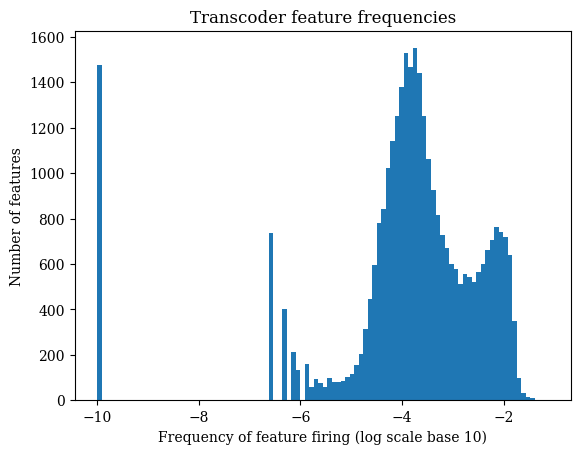

In [20]:
transcoder_sparsity = torch.load(f"{transcoder_path}_log_feature_sparsity.pt")
plt.hist(utils.to_numpy(transcoder_sparsity), bins=100)
plt.xlabel("Frequency of feature firing (log scale base 10)")
plt.ylabel("Number of features")
plt.title("Transcoder feature frequencies")
plt.show()

In [21]:
#transcoder_path = "sae_checkpoints/gelu-1l-transcoder/oahsgmrr/final_sparse_autoencoder_NeelNanda/GELU_1L512W_C4_Code_blocks.0.ln2.hook_normalized_32768"
#transcoder_path = "sae_checkpoints/gelu-1l-transcoder/sweep/lr_3_l1_2/final_sparse_autoencoder_NeelNanda/GELU_1L512W_C4_Code_blocks.0.ln2.hook_normalized_32768"
#transcoder = SparseAutoencoder.load_from_pretrained(f"{transcoder_path}.pt")
#transcoder = transcoder.eval()

#transcoder_sparsity = torch.load(f"{transcoder_path}_log_feature_sparsity.pt")
#plt.hist(utils.to_numpy(transcoder_sparsity), bins=100)
#plt.show()

Now, let's make a list of all of the non-dead features in the transcoder. For convenience we'll say that any feature that fires with a frequency of more than $10^{-6}$ is live.

In [22]:
transcoder_live_features = np.arange(len(transcoder_sparsity))[utils.to_numpy(transcoder_sparsity > -6)]
print(f"Number of live features: {len(transcoder_live_features)}")
print(f"Percentage of live features: {len(transcoder_live_features)/len(transcoder_sparsity)*100}%")
print(f"First 20 live feature indices: {', '.join(map(lambda x: str(x), transcoder_live_features[:30]))}")

Number of live features: 29812
Percentage of live features: 90.97900390625%
First 20 live feature indices: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32


## Quantitative evaluation

We'll quantitatively evaluate the efficacy of our transcoder in two ways:
1. We'll look at the mean L0 of the transcoder over a dataset of inputs. This is the mean number of features that are active on any given input. Ideally, this should be relatively low, since a lower L0 means that the transcoder is sparser.
2. We'll replace the model's MLP sublayer with the transcoder, measure the cross-entropy loss of the modified model for next-token prediction, and compare this to the cross-entropy loss of the original model, along with the cross-entropy loss of the model when the MLP is completely removed.

### L0

In [23]:
l0s = []
with torch.no_grad():
    for batch in tqdm.tqdm(range(0, 100)):
        _, cache = model.run_with_cache(owt_tokens_torch[batch*128:(batch+1)*128], stop_at_layer=1,
            names_filter=[utils.get_act_name('normalized0ln2', 0)])
        acts = cache[utils.get_act_name('normalized0ln2', 0)]
        binarized_transcoder_acts = 1.0*(transcoder(acts)[1] > 0)
        l0s.append(
            (binarized_transcoder_acts.reshape(-1, binarized_transcoder_acts.shape[-1])).sum(dim=1).mean().item()
        )

# memory management

import gc
del cache
del acts
del binarized_transcoder_acts
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
print(f"Mean L0: {np.mean(l0s)}")

Mean L0: 58.49754028320312


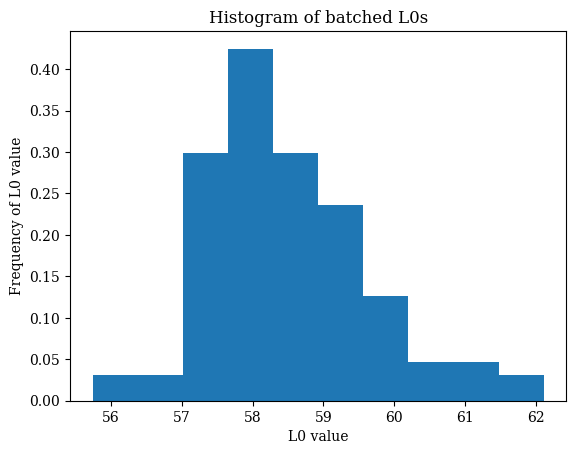

In [25]:
plt.hist(l0s, bins=10, density=True)
plt.xlabel("L0 value")
plt.ylabel("Frequency of L0 value")
plt.title("Histogram of batched L0s")
plt.show()

### CE loss

In [26]:
class TranscoderWrapper(torch.nn.Module):
    def __init__(self, transcoder):
        super().__init__()
        self.transcoder = transcoder
    def forward(self, x):
        return self.transcoder(x)[0]
class ZeroAblationWrapper(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x*0.0

real_losses = []
transcoder_losses = []
ablated_losses = []

old_mlp = model.blocks[0].mlp
with torch.no_grad():
    for batch in tqdm.tqdm(range(0, 200)):
        try:
            cur_batch_tokens = owt_tokens_torch[batch*64:(batch+1)*64]
            
            real_losses.append(utils.to_numpy(model(cur_batch_tokens, return_type="loss")))
            
            model.blocks[0].mlp = TranscoderWrapper(transcoder)
            transcoder_losses.append(utils.to_numpy(model(cur_batch_tokens, return_type="loss")))
            
            model.blocks[0].mlp = ZeroAblationWrapper()
            ablated_losses.append(utils.to_numpy(model(cur_batch_tokens, return_type="loss")))
        finally:
            model.blocks[0].mlp = old_mlp

  0%|          | 0/200 [00:00<?, ?it/s]

In [27]:
print(f"Original model cross-entropy loss: {np.mean(real_losses)}")
print(f"Cross-entropy loss when replacing MLP with transcoder: {np.mean(transcoder_losses)}")
print(f"Cross-entropy loss when removing MLP: {np.mean(ablated_losses)}")

Original model cross-entropy loss: 4.527946472167969
Cross-entropy loss when replacing MLP with transcoder: 4.861261367797852
Cross-entropy loss when removing MLP: 9.458603858947754


## Investigating live transcoder features

Now, we can investigate some transcoder features by seeing which logits they promote and which examples cause the feature to activate.

By changing the argument to `display_transcoder_feature()`, you can investigate different transcoder features.

  0%|          | 0/100 [00:00<?, ?it/s]

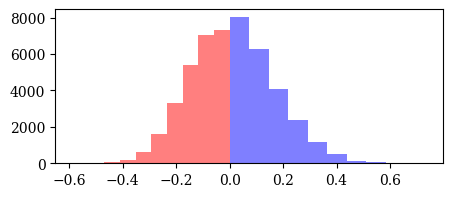

In [28]:
display_transcoder_feature(transcoder_live_features[0]) # the first live transcoder feature

Also, note that you can visualize transcoder feature activations on custom prompts.

In [157]:
display_transcoder_feature_scores_on_prompt("The prow of the ship sank under the billowing waves.", transcoder_live_features[0])

In [161]:
# batch multiple prompts at once
display_transcoder_feature_scores_on_prompt(['The Viking longship was notable for its remarkably-shaped prow.', 'What remarkable prowess!'], transcoder_live_features[0])

# Loading and evaluating our SAE

We'll now repeat the above evaluation for our SAE.

In [29]:
sae_path = "./sae"
sae = SparseAutoencoder.load_from_pretrained(f"{sae_path}.pt")
sae = sae.eval()

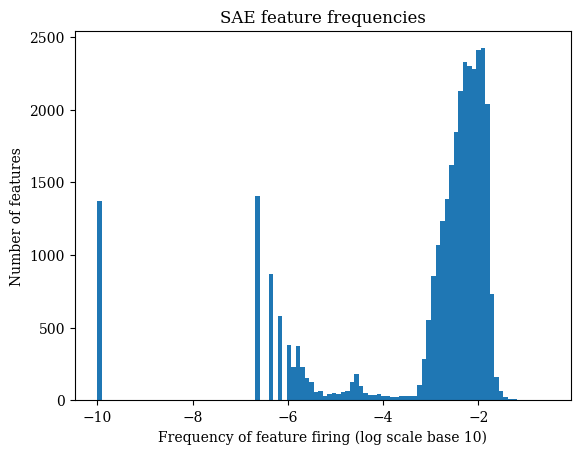

In [30]:
sae_sparsity = torch.load(f"{sae_path}_log_feature_sparsity.pt")
plt.hist(utils.to_numpy(sae_sparsity), bins=100)
plt.xlabel("Frequency of feature firing (log scale base 10)")
plt.ylabel("Number of features")
plt.title("SAE feature frequencies")
plt.show()

Now, let's make a list of all of the non-dead features in the SAE.

In [31]:
sae_live_features = np.arange(len(sae_sparsity))[utils.to_numpy(sae_sparsity > -6)]
print(f"Number of live features: {len(sae_live_features)}")
print(f"Percentage of live features: {len(sae_live_features)/len(sae_sparsity)*100}%")
print(f"First 20 live feature indices: {', '.join(map(lambda x: str(x), sae_live_features[:20]))}")

Number of live features: 28168
Percentage of live features: 85.9619140625%
First 20 live feature indices: 0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22


## Quantitative evaluation

### L0

In [32]:
l0s = []
with torch.no_grad():
    for batch in tqdm.tqdm(range(0, 100)):
        _, cache = model.run_with_cache(owt_tokens_torch[batch*128:(batch+1)*128], stop_at_layer=1,
            names_filter=[utils.get_act_name('mlp_out', 0)])
        acts = cache[utils.get_act_name('mlp_out', 0)]
        binarized_sae_acts = 1.0*(sae(acts)[1] > 0)
        l0s.append(
            (binarized_sae_acts.reshape(-1, binarized_sae_acts.shape[-1])).sum(dim=1).mean().item()
        )

# memory management

import gc
del cache
del acts
del binarized_sae_acts
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
print(f"Mean L0: {np.mean(l0s)}")

Mean L0: 177.43069519042967


If we're being honest, this L0 is pretty atrocious. But in the meantime, we'll just go ahead and use this SAE as a proof-of-concept.

### CE loss

In [34]:
def sae_hook(activations, hook):
    activations = sae.forward(activations)[0].to(activations.dtype)
    return activations

sae_losses = []
with torch.no_grad():
    for batch in tqdm.tqdm(range(0, 200)):
        cur_batch_tokens = owt_tokens_torch[batch*64:(batch+1)*64]
        sae_loss = model.run_with_hooks(
            cur_batch_tokens, return_type="loss", fwd_hooks=[(utils.get_act_name('mlp_out', 0), sae_hook)]
        ).item()
        sae_losses.append(sae_loss)

  0%|          | 0/200 [00:00<?, ?it/s]

In [35]:
print(f"Original model cross-entropy loss: {np.mean(real_losses)}")
print(f"Cross-entropy loss when replacing MLP-out activations with sae: {np.mean(sae_losses)}")
print(f"Cross-entropy loss when removing MLP: {np.mean(ablated_losses)}")

Original model cross-entropy loss: 4.527946472167969
Cross-entropy loss when replacing MLP-out activations with sae: 4.733119373321533
Cross-entropy loss when removing MLP: 9.458603858947754


## Investigating live SAE features

  0%|          | 0/100 [00:00<?, ?it/s]

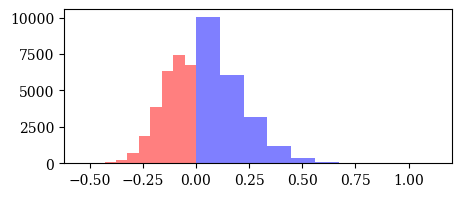

In [36]:
display_sae_feature(sae_live_features[0])

Also, note that you can visualize SAE feature activations on custom prompts.

In [154]:
display_sae_feature_scores_on_prompt("Reggae music is the best!", sae_live_features[0])

In [155]:
# batch multiple prompts at once
display_sae_feature_scores_on_prompt(['My friend Reg had a peg leg.', 'Regulatory bodies have enacted', "reg", ". greg"], sae_live_features[0])

# Case study: SAE feature 4949

Alright, let's start doing some reverse-engineering! We'll start with SAE feature 4949.

  0%|          | 0/100 [00:00<?, ?it/s]

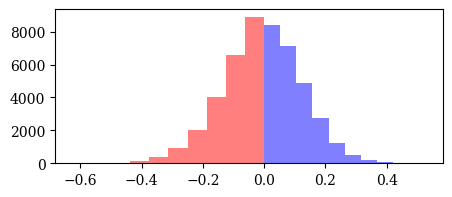

In [124]:
feature_idx = 4949

display_sae_feature(feature_idx)

There seems to be a clear pattern here. We'll use this as an opportunity to see if our reverse-engineering method gives us an output that makes sense.

## Input-independent connection to transcoder features

When we have an SAE feature, the first step is to see which transcoder features, when active, will cause the SAE feature to activate. In particular, we'll have a vector whose $i$-th component is proportional to the amount that transcoder feature $i$ causes the SAE feature to activate. Note that this is *input-independent information*, in the sense that it describes how important each transcoder feature is *if that transcoder feature is active*. But most transcoder features won't be active at any given time.

<details>
    <summary>Mathematical details</summary>

Recall that the transcoder implements the function $t(x) = W_{dec} ReLU(W_{enc} x)$ (ignoring bias terms). Also ignoring bias terms, the extent to which an SAE feature $f$ activates on $t(x)$ depends solely on $f_{enc}^T t(x)$. Thus, the activation of the SAE feature is $f_{enc}^T W_{dec} ReLU(W_{enc} x)$, which is just $(W_{dec}^T f_{enc})^T ReLU(W_{enc} x)$. Now, $ReLU(W_{enc} x)$ is the vector of transcoder feature activations; call this vector $z$. Then the SAE feature activation (ignoring bias) is given by the dot product of $W_{dec}^T f_{enc}$ with $z$. Thus, the amount that the $i$-th transcoder feature activation $z_i$ will cause the SAE feature to activate is proportional to the $i$-th component of $W_{dec}^T f_{enc}$.

Mathematically speaking, the linear functional $(W_{dec}^T f_{enc})^T$ is the *pullback* of the linear functional $f_{enc}^T$ by the matrix $W_{dec}$. In this case, you can think of the pullback as yielding a feature vector in the space of transcoder activations that corresponds to the original feature in the MLP-out space. Pullbacks will prove to be extremely useful throughout the reverse-engineering process.
  
</details>

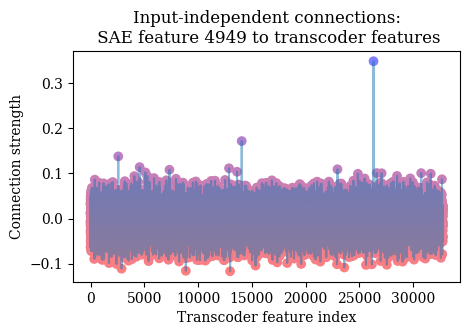

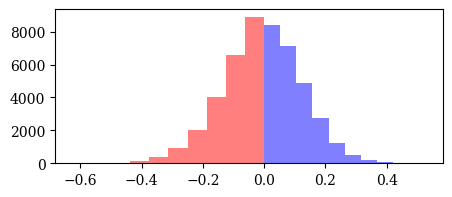

In [38]:
display_transcoder_features_for_sae_feature(model, sae, transcoder, feature_idx)

Looks like there's one transcoder feature in particular (feature 26324) that's very important for this SAE feature -- but a lot of other transcoder features with varying levels of importance.

## Input-dependent connection to transcoder features

Now, let's see which transcoder features contribute the most to making the SAE feature activate *on a given input*. We'll use token 48 from input example 1904, because this was one of the inputs that caused the SAE feature to activate the highest.

<details>
    <summary>Mathematical details</summary>

Earlier, we explained that if $z$ is the vector of transcoder feature activations and $f_{enc}$ is the encoder vector for the SAE feature, then (ignoring bias) the SAE feature activation is given by the dot product of $W_{dec}^T f_{enc}$ with $z$. Therefore, the SAE feature activation is given by $\sum_i (W_{dec}^T f_{enc})_i z_i$ over all transcoder features $i$. This means that the amount that transcoder feature $i$ contributes to the SAE feature activation is given by $(W_{dec}^T f_{enc})_i z_i$. Collecting all of these components into a single vector, our input-dependent contribution vector is given by the elementwise product $(W_{dec}^T f_{enc}) \odot z$.

Note that this corresponds to the classic "input-times-gradient" attribution method widely used in computer vision, where the input is the transcoder activation vector $z$ and the gradient is that of the function $z \mapsto f_{enc}^T (W_{dec} z)$ mapping transcoder activations to the SAE feature activation.
  
</details>

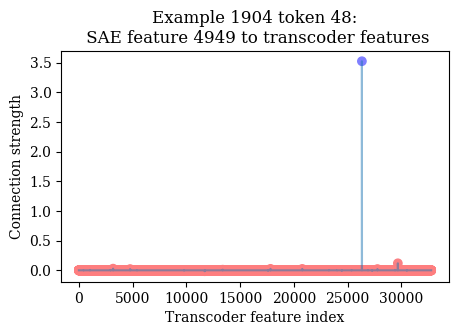

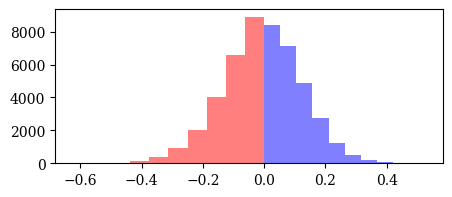

In [52]:
display_input_dependent_transcoder_features_for_sae_feature(model, sae, transcoder, feature_idx,
    input_example=1904, input_token_idx=48
)

Now, we see a much sparser graph -- it turns out that almost all of the contribution to the SAE feature activation comes from transcoder feature 26324!

## Transcoder feature de-embedding

Now, we can analyze this transcoder feature by performing a **de-embedding** on it. This will tell us which tokens, whenever seen in the direct path input to the transcoder, contribute most to causing the transcoder feature to activate. Importantly, this is also *input-independent information*.

<details>
    <summary>Mathematical details</summary>

The de-embedding is actually just another pullback. If $t_{enc}$ is the encoder vector for the transcoder feature, and $W_E$ is the model embedding matrix, then the de-embedding is calculated as $W_E^T t_{enc}$.
  
</details>

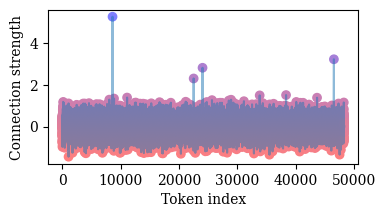

In [48]:
display_analysis_for_transcoder_feature(model, transcoder, 26324)

Sure enough, the tokens that cause the transcoder feature to fire the most are ` absolutely`, `Absolutely`, and `olutely` -- along with ` utterly`. It looks like our reverse-engineering corroborates the pattern that we saw in the top activating examples! 

# Case study: SAE feature 222

Let's do another case study. This time, we'll investigate a more complex SAE feature and learn how to incorporate attention into our analysis.

  0%|          | 0/100 [00:00<?, ?it/s]

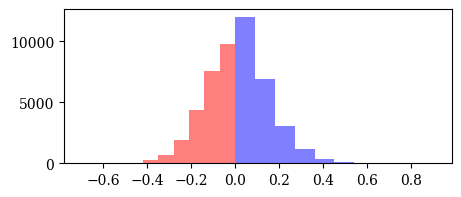

In [54]:
feature_idx = 222

display_sae_feature(feature_idx)

You can probably see what the pattern here is, but let's see what our reverse-engineering process has to say about it.

## Transcoder connections

First, we'll look at input-independent transcoder feature connections.

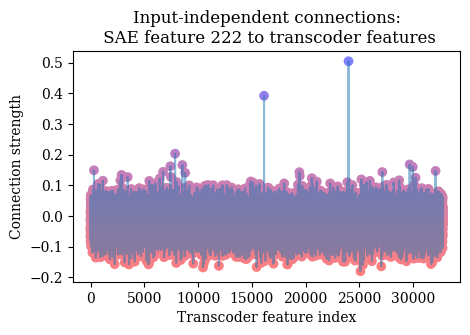

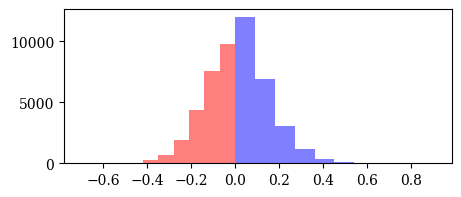

In [57]:
display_transcoder_features_for_sae_feature(model, sae, transcoder, feature_idx)

Already, we see that two transcoder features stand out: feature 23999 and feature 16141.

Now, let's look at which transcoder features are most responsible for the SAE feature firing on a couple of high-activating examples.

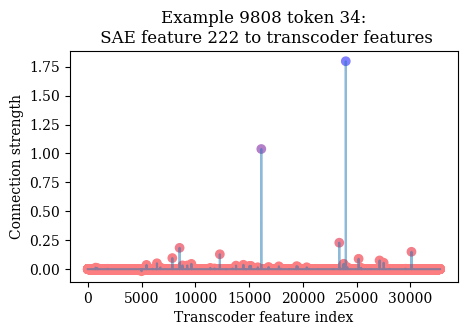

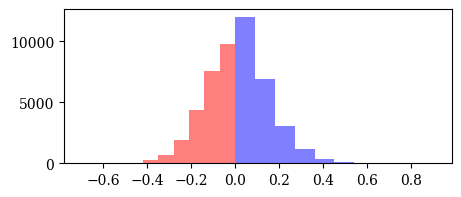

In [55]:
display_input_dependent_transcoder_features_for_sae_feature(model, sae, transcoder, feature_idx,
    input_example=9808, input_token_idx=34
)

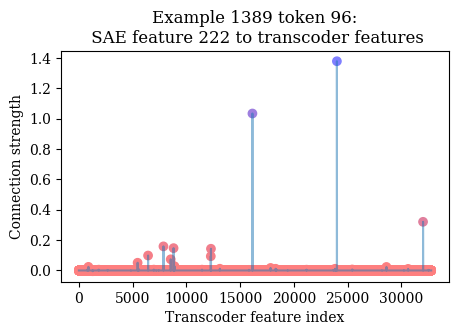

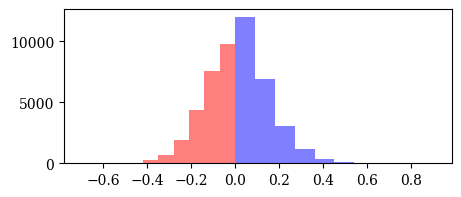

In [56]:
display_input_dependent_transcoder_features_for_sae_feature(model, sae, transcoder, feature_idx,
    input_example=1389, input_token_idx=96
)

Yep: on these high-activating examples, it's those same two features, 23999 and 16141. Let's investigate them in more detail.

## Transcoder feature de-embeddings

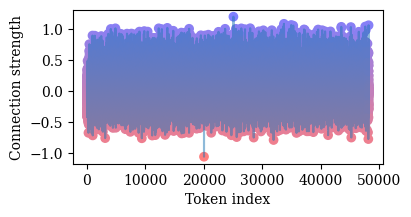

In [58]:
display_analysis_for_transcoder_feature(model, transcoder, 16141)

Interesting: the de-embedding for this transcoder feature suggests that the transcoder feature fires whenever the current token is a plural noun referring to a group of people.

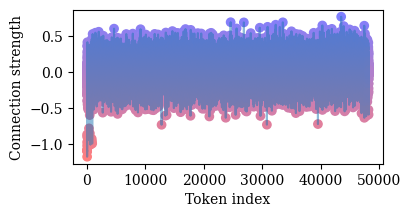

In [57]:
display_analysis_for_transcoder_feature(model, transcoder, 23999)

But for this transcoder feature, the direct path de-embedding is completely uninterpretable!

This might be a hint that transcoder fetaure 23999 isn't looking at the current token, but rather, utilizing attention in its computation.

## Attention direct feature attribution for transcoder feature 23999

In order to understand the extent to which attention is contributing to the activation of the transcoder feature, we can use a technique called **direct feature attribution**. This technique is similar to "direct logit attribution", a standard tool in the mechanistic interpretability toolbox -- but we apply it using transcoder feature vectors rather than logits.

<details>
    <summary>Mathematical details</summary>

Ignoring bias and LayerNorm, the activation of a transcoder feature on a pre-MLP hidden state $x$ is given by $t_{enc}^T x$, where $t_{enc}$ is the encoder vector of the transcoder feature. Now, in this one-layer model, $x$ can be written as the sum of the direct path token embedding and the output of attention. The output of attention is given by

$$ \sum_h \sum_s \mathrm{score}_h(s) W^{OV}_h x_s $$

summing over all attention heads $h$ and source tokens $s$, where $\mathrm{score}_h(s)$ is the attention score for head $h$ from source token $s$ to the destination token, $W^{OV}_h$ is the OV matrix for head $h$, and $x_s$ is the embedding for source token $s$.

Thus, the contribution of head $h$ and source token $s$ to the transcoder feature's activation is given by 

$$ t_{enc}^T \left(\mathrm{score}_h(s) W^{OV}_h x_s\right) $$

and storing these values for all heads $h$ and source tokens $s$ gives us our direct feature attribution for attention.
</details>

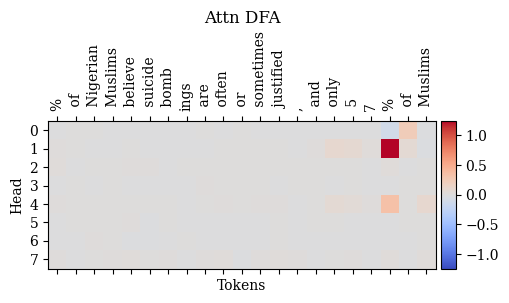

In [61]:
display_attn_dfa(model, feature_idx=23999, input_example=9808, token_idx=34)

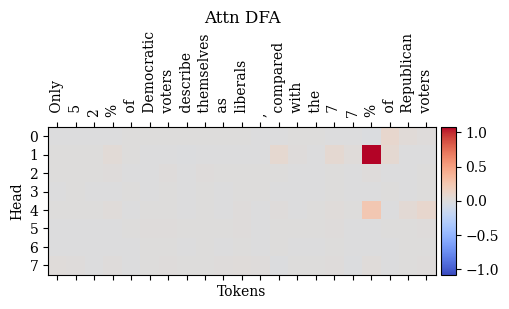

In [63]:
display_attn_dfa(model, feature_idx=23999, input_example=1389, token_idx=96)

Note that you can also do attention DFA on your own prompts, as follows:

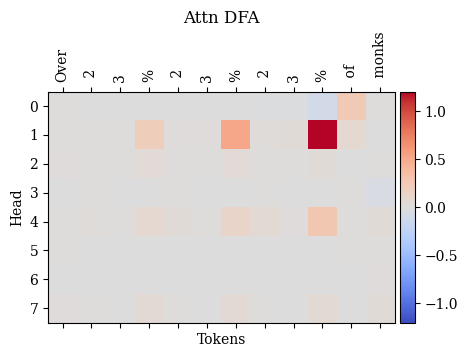

In [74]:
display_attn_dfa(model, feature_idx=23999, input_example="Over 23% 23% 23% of monks", token_idx=-1)
# token_idx=-1 means that we're looking at the last token in the prompt

It looks like we can see a clear pattern here: attention head 1 (and to a lesser extent, head 4) contribute to transcoder feature 23999 via the `%` token closest to the current token, with a roll-off (presumably due to QK circuit effects) as you get further and further away from the current token. Interesting!

## Attention de-embeddings for transcoder feature 23999

The next step is to get some *input-independent information* about how the OV circuits of each attention head contribute to the transcoder feature. To do this, we can apply the de-embedding process from earlier. This will tell us the following information: if we ignore the QK circuit of attention, then what tokens in the model's vocabulary will cause the attention head to contribute to the feature when present in the context?

(For the mathematically-inclined: here, we're taking the pullback of the transcoder encoder feature vector through the OV matrix of the attention head and then through the model unembedding matrix.)

In [75]:
display_deembeddings_for_transcoder_feature(model, transcoder, 23999, attn_head=1, k=7)
# k=7 means display seven examples

In [76]:
display_deembeddings_for_transcoder_feature(model, transcoder, 23999, attn_head=4, k=7)

Well, would you look at that! Our suspicious are confirmed: attention head 1's OV circuit contributes to the transcoder feature when it seems percent-related tokens in the context, and attention head 4 contributes when it sees a mix of percent-related and fraction-related tokens.

## Attention contribution to transcoder feature 16141

The other transcoder feature (16141) seemed to have a very interpretable direct path. But maybe it also acts via attention. Let's investigate.

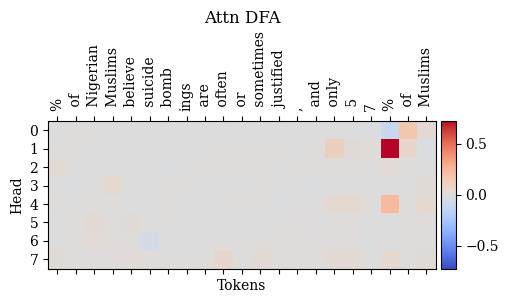

In [162]:
display_attn_dfa(model, feature_idx=16141, input_example=9808, token_idx=34)

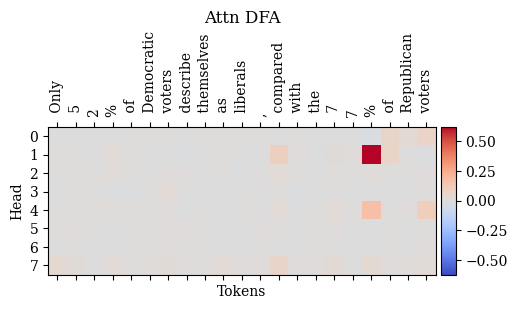

In [163]:
display_attn_dfa(model, feature_idx=16141, input_example=1389, token_idx=96)

Huh -- looks like heads 1 and 4 also contribute via the percent token to this feature, too! What do the de-embeddings have to say?

In [85]:
display_deembeddings_for_transcoder_feature(model, transcoder, 16141, attn_head=1, k=14)

In [83]:
display_deembeddings_for_transcoder_feature(model, transcoder, 16141, attn_head=4, k=14)

For attention head 1, once again, we see a bunch of percent-related tokens. For attention hed 4, we interestingly see fraction tokens given in words (e.g. "thirds", "half") but also lots of units of measurement (e.g. "gram", "nmol", "mircol" (as in "microliters")).

## Summing it up

In this case study, it seems that we've uncovered a mechanism that explains what the original SAE feature is doing. In particular -- the SAE feature depends on two transcoder features. One of the transcoder features largely contributes via the direct path, firing when the current token is a plural noun referring to groups of people. The other transcoder feature largely contributes via two attention heads, which fire on percent-related tokens and some fraction words. This explains the pattern that we saw in the top-activating examples, which tended to be of the form "... XX% of YY".

Note that this case study doesn't tell us quite the whole story about the feature. After all, we haven't really investigated the QK circuit of attention. But the case study does provide a very good idea of an important -- and interpretable -- mechanism underpinning the computation of the SAE feature.

# Now it's your turn!

I hope that after reading through this notebook, you now know how to embark on carrying out your own case studies. (If you don't, then let me know where you're confused, and I'll try to fix the notebook to better clarify things!) With this knowledge as your weapon, sally forth, and interpret some SAE features! In particular, here are some things to try out or look out for:

* When looking at the input-dependent transcoder feature connections on different inputs, do you find that different transcoder features are important for different inputs?
* After you've done some reverse-engineering and have developed a hypothesis about how your feature is being computed, can you use this understanding to construct *adversarial examples* for the feature -- that is, inputs that make the feature fire even though you wouldn't expect it?
* Are there any times when the reverse-engineering procedure would suggest that a feature fires on a certain input, but in reality, the feature doesn't fire?
* Also, a word of warning: the SAE and transcoder included by default with this notebook might not be the greatest. As such, if you find a feature that's hard to interpret, and reverse-engineering doesn't clarify things -- maybe it's just a bad feature.

I hope that you enjoy using this notebook to reverse-engineering your own features. Have fun!